# File for Severe vs Non Severe PNC

In [1]:
import pandas as pd

pnc_data = pd.read_csv("../BINN_elin/data/pnc_data.csv", sep=",")
translation = pd.read_csv("../BINN_elin/data/translation.csv", sep=",")
pathways = pd.read_csv("../BINN_elin/data/pathway.csv", sep=",")



In [2]:
#sps_data.head()
pnc_data.head()

,UniProt,DA07428,DA08797,DA08787,DA07439,DA07464,DA07415,DA09159,DA07469,DA07451,...,DA09160,DA09212,DA09218,DA09205,DA09197,DA07422,DA09178,DA09193,DA09181,DA09158
0,A1E959,0.79845,0.08115,0.58825,1.34445,-0.87885,-0.25615,0.05475,0.82135,0.64405,...,0.58615,1.66735,0.90695,3.28665,2.93295,0.03585,-0.44425,1.18185,0.12285,0.22045
1,O00548,2.02945,0.90425,0.59295,1.59835,0.36645,1.13885,-0.15775,0.09555,0.75185,...,1.43495,1.77255,2.76175,0.48155,1.90005,1.59035,0.49575,1.18025,1.21535,0.82645
2,O00622,2.65145,4.05815,2.13995,3.52915,4.75345,2.19695,0.74515,4.48955,2.22265,...,2.44325,0.34665,0.96365,1.88455,-0.13875,0.42615,0.68325,0.58635,0.95875,0.05665
3,O14793,-1.60670,-1.72950,-2.03200,-2.63390,0.26740,0.79990,-0.31150,0.61690,-2.83250,...,-0.54275,-0.31545,-3.12745,0.18375,-1.17305,-1.76655,-1.37945,0.30935,-1.07895,0.16275
4,O14836,1.49850,0.30470,0.05890,1.58290,0.79550,0.83940,0.52970,0.50080,-0.04680,...,0.83860,1.13640,2.29180,-1.34140,1.05220,1.33980,0.62680,5.12380,-0.06780,-0.14720


In [3]:
pathways.head()
#sps_pathways.shape

,target,source
0,R-HSA-109704,R-HSA-109703
1,R-HSA-109704,R-HSA-165158
2,R-HSA-1181150,R-HSA-1433617
3,R-HSA-1227986,R-HSA-1250196
4,R-HSA-1227986,R-HSA-1251932


In [4]:
translation.head()
#sps_pathways.shape

,input,translation
0,A1E959,R-HSA-977225
1,O00548,R-HSA-2122948
2,O00548,R-HSA-2644606
3,O00548,R-HSA-2660826
4,O00548,R-HSA-2691232


In [5]:
from  binn import Network
network_pnc = Network( 
    input_data=pnc_data,
    pathways=pathways,
    mapping=translation,
    input_data_column = "UniProt", # specify the column for entities in input data
    source_column = "source", # defined by our pathways-file
    target_column = "target"
)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [6]:
from binn import BINN

binn_pnc = BINN(
    network=network_pnc,
    n_layers=2,
    dropout=0.2,
    validate=False,
    device="cpu",
    learning_rate=0.001,
    )
binn_pnc.layers


BINN is on the device: cpu


Sequential(
  (Layer_0): Linear(in_features=36, out_features=52, bias=True)
  (BatchNorm_0): BatchNorm1d(52, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Dropout_0): Dropout(p=0.2, inplace=False)
  (Tanh 0): Tanh()
  (Layer_1): Linear(in_features=52, out_features=29, bias=True)
  (BatchNorm_1): BatchNorm1d(29, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Dropout_1): Dropout(p=0.2, inplace=False)
  (Tanh 1): Tanh()
  (Output layer): Linear(in_features=29, out_features=2, bias=True)
)

In [ ]:
binn_pnc.trainable_params

In [ ]:
layers = binn_pnc.layer_names
layers[0][0]

In [4]:
design_matrix_pnc = pd.read_csv("data/pnc_design_matrix.csv", sep=',')
#design_matrix_pnc

In [6]:
from docs.util_for_examples import fit_data_matrix_to_network_input, generate_data
import torch
from lightning.pytorch import Trainer



In [ ]:
print(network_pnc.inputs[:10])
print(pnc_data.head())


In [15]:
protein_matrix_pnc = fit_data_matrix_to_network_input(pnc_data, features=network_pnc.inputs, feature_column="UniProt")

protein_matrix_pnc.head()

,DA07428,DA08797,DA08787,DA07439,DA07464,DA07415,DA09159,DA07469,DA07451,DA08785,...,DA09160,DA09212,DA09218,DA09205,DA09197,DA07422,DA09178,DA09193,DA09181,DA09158
UniProt,,,,,,,,,,,,,,,,,,,,,
O00548,2.02945,0.90425,0.59295,1.59835,0.36645,1.13885,-0.15775,0.09555,0.75185,0.85435,...,1.43495,1.77255,2.76175,0.48155,1.90005,1.59035,0.49575,1.18025,1.21535,0.82645
O14836,1.49850,0.30470,0.05890,1.58290,0.79550,0.83940,0.52970,0.50080,-0.04680,0.57370,...,0.83860,1.13640,2.29180,-1.34140,1.05220,1.33980,0.62680,5.12380,-0.06780,-0.14720
O43557,1.64590,1.90780,2.55540,2.70160,0.48820,2.53680,1.88320,-0.70820,1.44260,2.07580,...,3.68570,2.43940,2.92680,1.10200,3.28630,2.38740,1.94950,0.75530,6.50900,1.59740
O60907,2.09945,2.13915,1.93185,0.45095,-0.81845,2.81905,-1.29525,-0.53395,0.52415,-0.44265,...,2.54770,0.17560,-0.13430,-0.45950,-1.46070,1.47930,0.34770,1.52010,4.62960,-0.14710
O75475,4.63890,1.46100,1.55190,3.54560,0.41140,5.66690,0.72440,-1.33400,0.78710,1.35650,...,3.09355,0.98845,3.04725,1.01885,2.03165,3.49525,0.84625,2.70515,4.84115,3.60495


In [16]:


X, y = generate_data(protein_matrix_pnc, design_matrix=design_matrix_pnc)
dataset = torch.utils.data.TensorDataset(
    torch.tensor(X, dtype=torch.float32, device=binn_pnc.device),
    torch.tensor(y, dtype=torch.int16, device=binn_pnc.device),
)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)

# You can train using the Lightning Trainer
trainer = Trainer(max_epochs=10, log_every_n_steps=10)
#trainer.fit(binn_sps, dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
y

In [17]:
from binn import BINNExplainer

explainer_pnc = BINNExplainer(binn_pnc)

In [18]:
test_data = torch.Tensor(X)
background_data = torch.Tensor(X)

n_iterations = 20
n_epochs = 30

importance_df_pnc, metrics_pnc = explainer_pnc.explain_average(
    test_data, background_data, n_iterations, n_epochs, dataloader, fast_train=True
)


Iteration 0
Final epoch: Average Accuracy 0.84, Average Loss: 0.45
Iteration 1
Final epoch: Average Accuracy 0.66, Average Loss: 0.60
Iteration 2
Final epoch: Average Accuracy 0.70, Average Loss: 0.57
Iteration 3
Final epoch: Average Accuracy 0.70, Average Loss: 0.57
Iteration 4
Final epoch: Average Accuracy 0.73, Average Loss: 0.59
Iteration 5
Final epoch: Average Accuracy 0.79, Average Loss: 0.44
Iteration 6
Final epoch: Average Accuracy 0.82, Average Loss: 0.40
Iteration 7
Final epoch: Average Accuracy 0.71, Average Loss: 0.51
Iteration 8
Final epoch: Average Accuracy 0.75, Average Loss: 0.51
Iteration 9
Final epoch: Average Accuracy 0.70, Average Loss: 0.55
Iteration 10
Final epoch: Average Accuracy 0.77, Average Loss: 0.44
Iteration 11
Final epoch: Average Accuracy 0.77, Average Loss: 0.50
Iteration 12
Final epoch: Average Accuracy 0.88, Average Loss: 0.41
Iteration 13
Final epoch: Average Accuracy 0.70, Average Loss: 0.60
Iteration 14
Final epoch: Average Accuracy 0.75, Average L

In [29]:
metrics_pnc

{0: {'accuracies': [0.5,
   0.5892857313156128,
   0.6071428656578064,
   0.5892857313156128,
   0.6428571343421936,
   0.7142857313156128,
   0.625,
   0.7321428656578064,
   0.75,
   0.75,
   0.7678571343421936,
   0.7321428656578064,
   0.6964285969734192,
   0.7857142686843872,
   0.8035714030265808,
   0.7678571343421936,
   0.7678571343421936,
   0.7321428656578064,
   0.7678571343421936,
   0.75,
   0.8214285969734192,
   0.7857142686843872,
   0.8035714030265808,
   0.8035714030265808,
   0.6785714030265808,
   0.7678571343421936,
   0.7857142686843872,
   0.75,
   0.8214285969734192,
   0.8392857313156128],
  'losses': [0.8233949031148639,
   0.7309002450534275,
   0.7478927969932556,
   0.7263801864215306,
   0.6258400678634644,
   0.6697465479373932,
   0.5942949439798083,
   0.5395809454577309,
   0.5244176047188895,
   0.5279399539743151,
   0.5036496818065643,
   0.5724878098283496,
   0.5939142831734249,
   0.5042718010289329,
   0.564109912940434,
   0.5123794589723859,

In [ ]:
import torch.nn.functional as F

# You can also train with a standard PyTorch train loop 

optimizer = binn_pnc.configure_optimizers()[0][0]

num_epochs = 30

for epoch in range(num_epochs):
    binn_pnc.train() 
    total_loss = 0.0
    total_accuracy = 0

    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs = inputs.to(binn_pnc.device)
        targets = targets.to(binn_pnc.device).type(torch.LongTensor)
        optimizer.zero_grad()
        outputs = binn_pnc(inputs).to(binn_pnc.device)
        loss = F.cross_entropy(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_accuracy += torch.sum(torch.argmax(outputs, axis=1) == targets) / len(targets)

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_accuracy / len(dataloader)
    print(f'Epoch {epoch}, Average Accuracy {avg_accuracy}, Average Loss: {avg_loss}')


In [ ]:
test_data = torch.Tensor(X[5:10])
background_data = torch.Tensor(X[0:5])


importance_df_pnc = explainer_pnc.explain(test_data, background_data)

In [19]:
importance_df_pnc

,source,target,source name,target name,type,source layer,target layer,value_0,value_1,value_2,...,value_13,value_14,value_15,value_16,value_17,value_18,value_19,value_mean,values_std,value
0,1,79,O00548,R-HSA-9022702,0,0,1,0.318716,0.053923,0.007466,...,0.066069,0.124450,0.257760,0.145993,0.042453,0.071538,0.270772,0.151058,0.096492,0.151058
1,1,79,O00548,R-HSA-9022702,1,0,1,0.034366,0.372120,0.071703,...,0.301156,0.168784,0.126811,0.257569,0.223108,0.271181,0.180103,0.168557,0.106034,0.168557
2,1,88,O00548,R-HSA-9824272,0,0,1,0.318716,0.053923,0.007466,...,0.066069,0.124450,0.257760,0.145993,0.042453,0.071538,0.270772,0.151058,0.096492,0.151058
3,1,88,O00548,R-HSA-9824272,1,0,1,0.034366,0.372120,0.071703,...,0.301156,0.168784,0.126811,0.257569,0.223108,0.271181,0.180103,0.168557,0.106034,0.168557
4,2,67,O14836,R-HSA-5669034,0,0,1,0.002567,0.000291,0.004321,...,0.002091,0.007764,0.009872,0.006758,0.002253,0.004799,0.034372,0.008282,0.010800,0.008282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,115,0,R-HSA-9703648,root,1,2,3,0.112309,0.246625,0.211599,...,0.074688,0.064762,0.185222,0.128501,0.198689,0.253425,0.022581,0.122359,0.069733,0.122359
332,116,0,R-HSA-9707564,root,0,2,3,0.026146,0.148552,0.150529,...,0.127900,0.181940,0.024908,0.059295,0.145227,0.085896,0.075697,0.103836,0.071000,0.103836
333,116,0,R-HSA-9707564,root,1,2,3,0.155926,0.000155,0.087642,...,0.162113,0.158100,0.179598,0.031173,0.088944,0.031224,0.162326,0.123178,0.069154,0.123178
334,117,0,R-HSA-9793380,root,0,2,3,0.297510,0.097538,0.033844,...,0.081561,0.083822,0.086316,0.018613,0.074270,0.088870,0.269251,0.112110,0.082116,0.112110


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.jointplot(plot_df, y="mean", x="std", hue="source layer", palette="coolwarm")

#plt.savefig("pnc_robustness.png", dpi=500)


# Start working from here!!

In [ ]:
#importance_df_pnc.to_csv('data/importance_df_pnc_erik.csv', sep = '\t', index=False)

In [ ]:
import pandas as pd
importance_df_pnc = pd.read_csv('data/importance_df_pnc_erik.csv', sep = '\t')
#importance_df_pnc = pd.read_csv('data/importance_df_pnc.csv', sep = '\t')
importance_df_pnc.head()

In [20]:
from binn import ImportanceNetwork

IG_pnc = ImportanceNetwork(importance_df_pnc, norm_method="fan")

#IG_pnc.importance_df.sort_values("value", ascending=False).head()

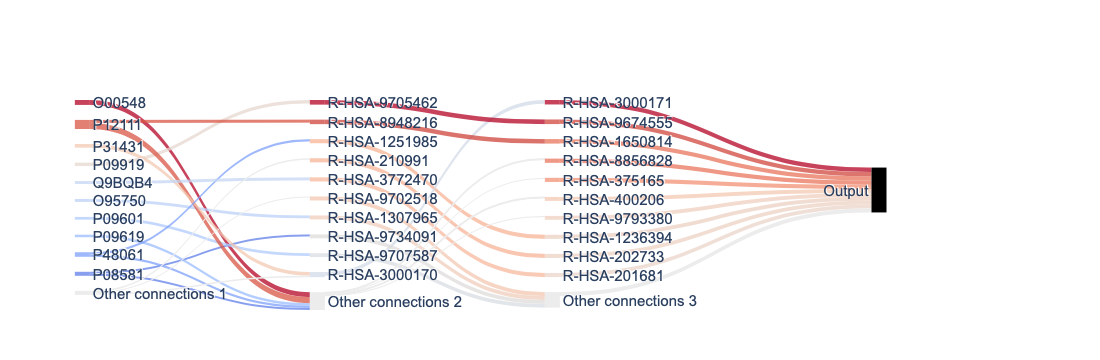

In [21]:
IG_pnc.plot_complete_sankey(
    multiclass=False, node_cmap="coolwarm", edge_cmap="coolwarm"
)

In [22]:
source_proteome = pd.read_csv("data/source.csv", sep= ",")

source_mapping = (
    source_proteome.set_index("id").to_dict()["name"]
)

source_mapping.update({"root": "root"})


#source_mapping

In [23]:
plot_df = importance_df_pnc.copy()
plot_df["source name"] = plot_df["source name"].map(source_mapping)
plot_df["target name"] = plot_df["target name"].map(source_mapping)
plot_df.head()

,source,target,source name,target name,type,source layer,target layer,value_0,value_1,value_2,...,value_13,value_14,value_15,value_16,value_17,value_18,value_19,value_mean,values_std,value
0,1,79,DLL1,MECP2 regulates transcription of neuronal ligands,0,0,1,0.318716,0.053923,0.007466,...,0.066069,0.124450,0.257760,0.145993,0.042453,0.071538,0.270772,0.151058,0.096492,0.095307
1,1,79,DLL1,MECP2 regulates transcription of neuronal ligands,1,0,1,0.034366,0.372120,0.071703,...,0.301156,0.168784,0.126811,0.257569,0.223108,0.271181,0.180103,0.168557,0.106034,0.106347
2,1,88,DLL1,Somitogenesis,0,0,1,0.318716,0.053923,0.007466,...,0.066069,0.124450,0.257760,0.145993,0.042453,0.071538,0.270772,0.151058,0.096492,0.095307
3,1,88,DLL1,Somitogenesis,1,0,1,0.034366,0.372120,0.071703,...,0.301156,0.168784,0.126811,0.257569,0.223108,0.271181,0.180103,0.168557,0.106034,0.106347
4,2,67,TNFRSF13B,TNFs bind their physiological receptors,0,0,1,0.002567,0.000291,0.004321,...,0.002091,0.007764,0.009872,0.006758,0.002253,0.004799,0.034372,0.008282,0.010800,0.008282


In [24]:
from binn import ImportanceNetwork
IG_plot = ImportanceNetwork(plot_df, norm_method="fan")

In [ ]:
IG_plot.importance_df.head()

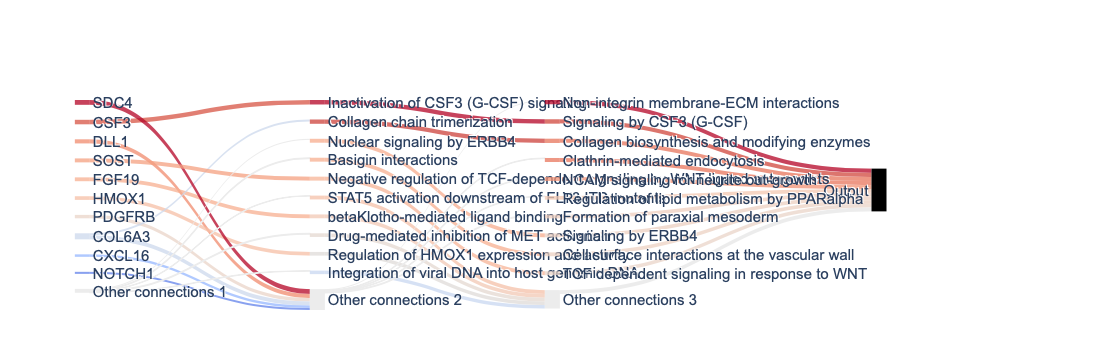

In [25]:
IG_plot.plot_complete_sankey(
    multiclass=False, node_cmap="coolwarm", edge_cmap="coolwarm", savename='pnc_sankey_erik.png'
)

In [ ]:
IG_plotplot_subgraph_sankey(query_node = "A1E959_0")

In [ ]:
#IG_sps.importance_df.to_csv('data/imp_df_sps_new.csv', sep = '\t', index=False)

# Robustness plot

In [ ]:
importance_df_copy = importance_df_pnc.groupby(["source name", "source layer", "target layer"], as_index=False).mean(numeric_only=True)
mean_ranks = []
std_ranks = []
source_layer = []
sources = []
for layer in range(binn_pnc.n_layers):
    layer_df = importance_df_copy[importance_df_copy["source layer"] == layer].copy()
    for i in range(n_iterations):
        layer_df.sort_values(f"value_{i}", ascending=False, inplace=True)
        layer_df[f"rank_{i}"] = range(len(layer_df.index))
    rank_cols = [c for c in layer_df.columns if c.startswith("rank")]
    mean_ranks += (layer_df[rank_cols].mean(axis=1)/ len(layer_df.index)).tolist()
    sources += layer_df["source name"].tolist()
    std_ranks  += (layer_df[rank_cols].std(axis=1)/ len(layer_df.index)).tolist()
    source_layer += layer_df["source layer"].tolist()
plot_df = pd.DataFrame({"mean":mean_ranks, "std":std_ranks, "source layer":source_layer, "source":sources})

# Biomarkers

In [26]:
biomarkers = IG_plot.importance_df[IG_plot.importance_df["source layer"] == 0].copy()
biomarkers = biomarkers.groupby("source name").mean(numeric_only=True)
biomarkers = biomarkers.sort_values("value", ascending=False)["source"][
    0:10
].index.tolist()

In [27]:
#biomarkers.tofile('data/pnc_biomarkers.csv', sep=',', format='%s')
biomarkers

['SDC4',
 'CSF3',
 'SOST',
 'FGF19',
 'HMOX1',
 'PDGFRB',
 'CXCL16',
 'DLL1',
 'NOTCH1',
 'COL6A3']

In [ ]:
biomarkers = IG_pnc.importance_df[IG_pnc.importance_df["source layer"] == 0].copy()
biomarkers = biomarkers.groupby("source name").mean(numeric_only=True)
biomarkers = biomarkers.sort_values("value", ascending=False)["source"][
    0:100
].index.tolist()

biomarker_data = protein_matrix_pnc.loc[biomarkers].fillna(0)

from sklearn.preprocessing import StandardScaler
from umap import UMAP

cols = biomarker_data.columns
index = biomarker_data.index
biomarker_data = StandardScaler().fit_transform(biomarker_data.T).T

X_reduced = UMAP(random_state=42).fit_transform(biomarker_data.T)

row_colors = design_matrix_pnc["group"].map({1: "#398fcc", 2: "#c42412"}).values

biomarker_data = pd.DataFrame(data=biomarker_data, columns=cols, index=index)

g = sns.clustermap(
    biomarker_data,
    col_colors=row_colors,
    figsize=(5, 6),
    vmin=-2,
    vmax=2,
    cmap="coolwarm",
    cbar_kws={"label": "z-score"},
)
#g.ax_heatmap.set_xticks([])

In [ ]:
import csv

# Open a CSV file in write mode
with open('data/pnc_biomarkers_new.csv', 'w', newline='') as csvfile:
    # Create a CSV writer object
    writer = csv.writer(csvfile, delimiter=',')
    
    # Write the biomarkers to the CSV file
    writer.writerow(biomarkers)


In [ ]:
umap_df = pd.DataFrame(data=X_reduced, columns=["UMAP1", "UMAP2"])
umap_df["group"] = design_matrix_pnc["group"].values
umap_df.reset_index(inplace=True)


plt.figure(figsize=(5,4))
sns.scatterplot(umap_df, x="UMAP1", y ="UMAP2", hue="group", palette=["#398fcc", "#c42412"])
plt.legend(frameon=False, title="Severity")
sns.despine()
plt.tight_layout()
plt.xticks([])
plt.yticks([])
#plt.savefig("poster_biomarkers_umap.png", dpi=500)

    accuracies    losses  epoch  model
0     0.500000  0.823395      0      0
1     0.589286  0.730900      1      0
2     0.607143  0.747893      2      0
3     0.589286  0.726380      3      0
4     0.642857  0.625840      4      0
..         ...       ...    ...    ...
25    0.696429  0.543170     25     19
26    0.767857  0.513683     26     19
27    0.803571  0.521607     27     19
28    0.785714  0.523183     28     19
29    0.678571  0.672476     29     19

[600 rows x 4 columns]


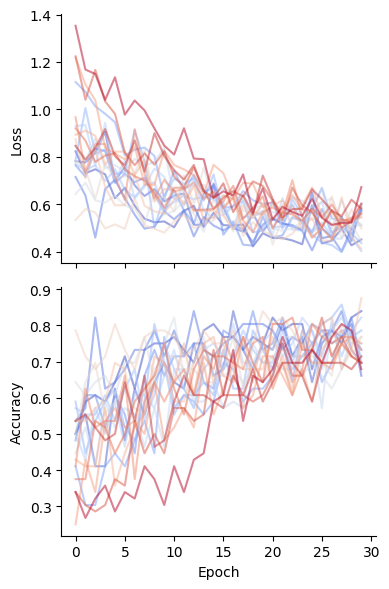

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

all_metrics = []

for model, metric in metrics_pnc.items():
    metric["model"] = [model] * len(metric["accuracies"])
    all_metrics.append(pd.DataFrame(metric))

all_metrics = pd.concat(all_metrics)
print(all_metrics)

fig, axs = plt.subplots(2, 1, figsize=(4, 6), sharex=True)
sns.lineplot(
    all_metrics,
    x="epoch",
    y="losses",
    hue="model",
    ax=axs[0],
    palette="coolwarm",
    alpha=0.5,
)
sns.lineplot(
    all_metrics,
    x="epoch",
    y="accuracies",
    hue="model",
    ax=axs[1],
    palette="coolwarm",
    alpha=0.5,
)
for ax in axs.ravel():
    sns.despine(ax=ax)
    ax.legend().remove()

plt.tight_layout()


axs[0].set_ylabel("Loss")
axs[1].set_ylabel("Accuracy")
axs[1].set_xlabel("Epoch")
plt.savefig("pnc_acc_loss.png", dpi=300)